In [1]:
import components
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### simulation

#### initialize helper objects for simulation
- SimulationBroker
- VehicleGenerator
- ResultWriter

In [2]:
# simulation broker
path_Sim = "test_data/beam1/beam1-0.csv"
dtype_Sim = {
       'time': 'int64', 'type': 'category', 'vehicle': 'int64', 'parkingTaz': 'category','chargingPointType': 'category', 
       'primaryFuelLevel': 'float64', 'mode': 'category', 'currentTourMode': 'category', 'vehicleType': 'category', 
       'arrivalTime': 'float64', 'departureTime': 'float64', 'linkTravelTime': 'string', 'primaryFuelType': 'category', 
       'parkingZoneId': 'category','duration': 'float64' 
        }
SimBroker = components.SimBroker(path_Sim, dtype_Sim)

# vehicle generator
path_DataBase = "test_data/vehicleFiles/vehicletypes-Base_2035_20210204_updated.csv"
VehicleGenerator = components.VehicleGenerator(path_Sim, dtype_Sim, path_DataBase)

sim_name = "sim1"
result_directory = "results"
ResultWriter = components.ResultWriter(result_directory, sim_name)

In [3]:
# show head of vehicles dataframe
VehicleGenerator.vehicles.head(3)

,vehicleType
vehicle,
2517,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
9368,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
11104,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC


#### create charging stations
1) map parkingZoneIds to charging stations with a dictionary
2) create charging Stations

In [4]:
# load infrastructure file into dataframe
path_infrastructure = "test_data/beam1/gemini-base-scenario-3-charging-no-household-infra16.csv"
usecols_infrastructure = ["taz", "parkingType", "chargingPointType", "parkingZoneId"]
dtype_infrastructure = {"taz": "int64", "parkingType": "category", "chargingPointType": "category", "parkingZoneId": "string"}
infrastructure = pd.read_csv(path_infrastructure, dtype=dtype_infrastructure, usecols=usecols_infrastructure)
infrastructure = infrastructure.set_index("parkingZoneId")
# filter infrastructure for only public fast and extreme fast charging
infrastructure = infrastructure.loc[infrastructure["parkingType"] == "Public"]
infrastructure = infrastructure.loc[infrastructure["chargingPointType"].str.contains("publicfc|publicxfc")]
infrastructure = infrastructure.sort_values(by = ["taz", "parkingZoneId"])

#now, make a dict of every parkingZoneId that belongs to a charging station
# here, we will split the chargingstation
chargingStationMappedToParkingZoneId = {}
chargingStationMappedToTaz = {}
stepsize = 200
i = 0 
j = 1
stop = False
while i < len(infrastructure) -1 :
    name = "chargingStation-" + str(j)
    # we want to make sure, that all the chargingBays of one TAZ are in one chargingStation
    if i + stepsize < len(infrastructure) :
        i_end = i+stepsize
        while infrastructure.iloc[i_end]["taz"] == infrastructure.iloc[i_end+1]["taz"]:
            i_end +=1 # if the taz is the same, we should increase reading to that taz
            if i_end +1 >= len(infrastructure) - 1 : # make sure, that we don't try to read in the next step something that doesnt exist
                stop = True
                break
    else: 
        i_end = len(infrastructure)-1
    if not stop:
        i_end += 1 # to also catch the last element
    slice = infrastructure.iloc[i:i_end]
    chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
    chargingStationMappedToTaz[name] = list(set(slice["taz"].to_list())) # this removes duplicates
    i = i_end # start reading next cycle at i
    j += 1

# we convert chargingStationMappedToTaz to a dataframe to use search methods
chargingStationMappedToTaz = pd.DataFrame.from_dict(chargingStationMappedToTaz, orient='index')
chargingStationMappedToTaz = chargingStationMappedToTaz.transpose()

# #here, we will make chargingStation depending on TAZ. Therefore, get a list of the different TAZ and sort it:
# taz = infrastructure.taz.drop_duplicates().to_list()
# taz = sorted(taz)
# while i < len(taz):
#     name = "chargingStation-" + str(j)
#     # slice = infrastructure.loc[infrastructure["taz"].isin(taz[i:i+stepsize])]
#     chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
#     i += stepsize
#     j += 1

In [5]:
infrastructure.head(3)

,taz,parkingType,chargingPointType
parkingZoneId,,,
X-PEV-9-1,9,Public,publicfc(150.0|DC)
X-PEV-11-1,11,Public,publicfc(150.0|DC)
X-PEV-12-1,12,Public,publicfc(150.0|DC)


In [6]:
chargingStationMappedToTaz.head(3)

,chargingStation-1,chargingStation-2,chargingStation-3
0,518.0,947.0,1280.0
1,520.0,948.0,1412.0
2,9.0,949.0,1273.0


here, charging stations are created. please specifiy the type of charging station you want to use

In [7]:
#create chargingStations
'''specifiy here chargingStation'''
import components.ChaDepMpcBase as chargingStationClass

chargingStations = [] # list of charging stations
for i in chargingStationMappedToParkingZoneId:
    #chargingStations.append(i)

    ChargingStationId = i
    # make a list with the powers of the bays:
    ChBaMaxPower = []
    for j in chargingStationMappedToParkingZoneId[i]:
        power_string = infrastructure.loc[j, "chargingPointType"]
        ChBaMaxPower.append(components.chargingCapFromString(power_string))
    # for now, we assume that all charging bays have the same charging power
    PowerMax = max(ChBaMaxPower)
    len_power = len(ChBaMaxPower)
    ChBaMaxPower = []

    # make charging limit for each bay the same (for testing and simplicity)
    for j in range(0, len_power):
        ChBaMaxPower.append(PowerMax)
    del PowerMax, len_power
    
    ChBaParkingZoneId = chargingStationMappedToParkingZoneId[i]
    calcBtmsGridProp = True
    
    '''reduce number of charging bays to test controller'''
    # numStations = 30
    # ChBaMaxPower = ChBaMaxPower[0:numStations]
    ChBaNum = len(ChBaMaxPower)
    
    ## specify here charging station
    container = chargingStationClass(ChargingStationId=ChargingStationId, ResultWriter=ResultWriter, SimBroker = SimBroker, ChBaMaxPower=ChBaMaxPower, ChBaParkingZoneId=ChBaParkingZoneId, ChBaNum = ChBaNum ,calcBtmsGridProp = True)
    chargingStations.append(container)
    print(ChargingStationId + " was created with " + str(container.ChBaNum) + " charging bays and " + str(container.BtmsSize) + "kWh BTM-Storage")

'''write charging station properties to ResultWriter'''
ResultWriter.saveChargingStationProperties(chargingStations)

chargingStation-1 was created with 208 charging bays and 26000.0kWh BTM-Storage
chargingStation-2 was created with 207 charging bays and 25875.0kWh BTM-Storage
chargingStation-3 was created with 93 charging bays and 11625.0kWh BTM-Storage


- initialize helper objects for simulation input

In [8]:
PhySimDummy = components.PhySimDummy(chargingStations)
DermsDummy  = components.DermsDummy(chargingStations)

#### initialize simulation
initialize Grid Constraints and actual time of charging Station

In [9]:
#reduce number of chargingStation for testing
if False:
    chargingStations = [chargingStations[0]]

In [10]:
'''Simulation settings:'''
timestep = 5 * 60

In [11]:
for x in chargingStations:
    GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
    x.initialize(GridPowerLower = GridPowerLower, GridPowerUpper = GridPowerUpper)
    # TODO is this necessary in the way this is set up? updated before vehicle arrival!

generate predictions for power use of charging station

In [12]:
if chargingStationClass == components.ChaDepMpcBase:
    for x in chargingStations:
        x.generatePredictions(path_BeamPredictionFile = path_Sim, dtype = dtype_Sim, path_DataBase = path_DataBase, timestep = timestep, addNoise = True)

plot prediction 

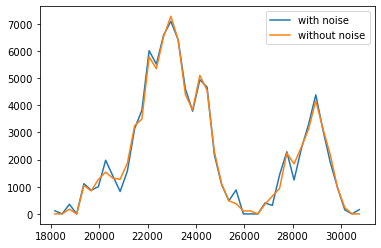

In [13]:
if chargingStationClass == components.ChaDepMpcBase:
    x = chargingStations[0]
    time = x.PredictionTime
    power = x.PredictionPower

    ax = plt.subplot()
    ax.plot(time,power, label = 'with noise')
    ax.plot(time,x.power_sum_original, label = 'without noise')
    ax.legend()

BTMS size optimization

see mpcBase.md for explanations

459.8823671053456
269.2242693754837
184.9558878346967


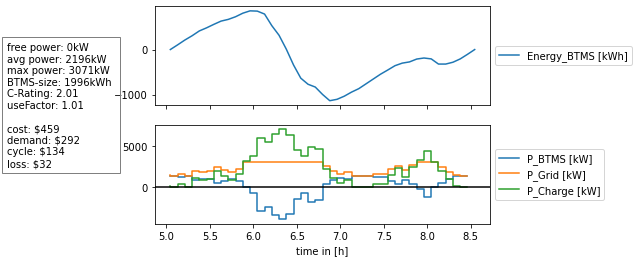

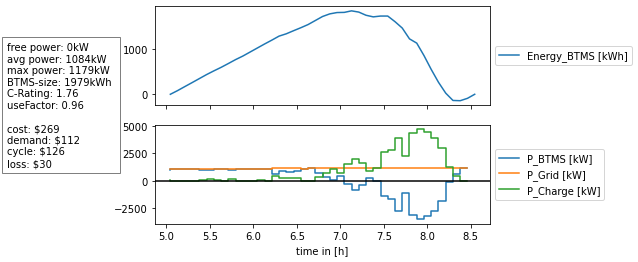

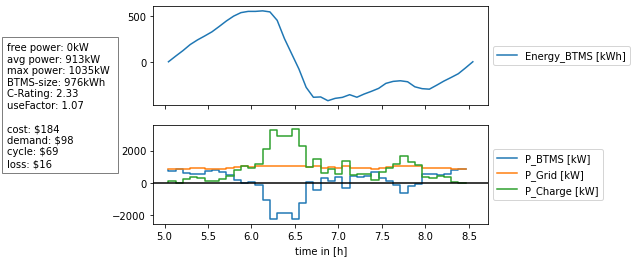

In [14]:
if chargingStationClass == components.ChaDepMpcBase:
    a               = 20/30 * ((SimBroker.t_max - SimBroker.t_act)/3.6e3)/24       # demand charge per day
    P_free_Ratio    =  0      # free power, after which demand charge is applied, as ratio to avg power
    b               = 300/5000    # btms cost per cycle per kWh (price per kWh/ possible cycles)
    c               = 0.15      # electricity cost per kWh

    Print = False
    Graph = True
    for i in range(0, len(chargingStations)):
        x = chargingStations[i]
        #determine P_free
        avgPower = sum(x.PredictionPower*timestep)/(max(x.PredictionTime) + timestep - min(x.PredictionTime))
        P_free = P_free_Ratio *avgPower
        time, time_x, btms_size, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, P_Charge, cost = x.determineBtmsSize(SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, P_free)
        time = time/3.6e3 #conversion to hours
        time_x = time_x/3.6e3
        if Print:
            print('\n', x.ChargingStationId)
            print('Optimization with free power level of', int(P_free), 'kW')
            print('The determined effective BTMS size is', int(btms_size), 'kWh.')
            cRating = max(abs(P_BTMS))/btms_size
            print('The associated C-Rating is', cRating)
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) + sum(P_BTMS_DCh*timestep/3.6e3)) # btmsDCh is always negative
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            print('The cost-value is $', int(cost), 'from which $', int(a*(max(P_Grid)-P_free)), 'is associated with demand charge, $', int(costCycle), 'is associated with BTMS degradation and $', int(costLoss), 'is associated with energy losses')
            E_total = sum(timestep/3.6e3*P_Charge)
            print('The total delivered energy to the vehicles is', int(E_total), 'kWh, which results in an average power of' , int(E_total/(max(time)-min(time) + timestep/3.6e3)), 'kW')
            print(int(-sum(P_BTMS_DCh*timestep/3.6e3)), 'kWh were delivered by the BTMS and charging losses of', int(sum(P_BTMS_DCh*timestep/3.6e3) + sum(P_BTMS_Ch*timestep/3.6e3)), 'kWh occured.')
            print('The maximal grid power is', int(max(P_Grid)), 'kW')

        if Graph:
            cRating = max(abs(P_BTMS))/btms_size
            E_total = sum(timestep/3.6e3*P_Charge)
            avgPower = int(E_total/(max(time)-min(time) + timestep/3.6e3))
            useFactor = -sum(P_BTMS_DCh*timestep/3.6e3) / btms_size
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) + sum(P_BTMS_DCh*timestep/3.6e3)) # btmsDCh is always negative
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            costDemand = a*(max(P_Grid)-P_free)
            info_string1 = 'free power: ' + str(int(P_free)) + 'kW \navg power: '+ str(int(avgPower)) +'kW \nmax power: ' + str(int(max(P_Grid))) +'kW \nBTMS-size: ' + str(int(btms_size)) + 'kWh \nC-Rating: ' + "{:.2f}".format(cRating) + ' \nuseFactor: ' + "{:.2f}".format(useFactor) +' \n\ncost: $' + str(int(cost)) + ' \ndemand: $' +str(int(costDemand)) + '\ncycle: $' + str(int(costCycle)) + '\nloss: $' + str(int(costLoss))

            fig, ax = plt.subplots(2,1, sharex = True)

            ax[0].plot(time_x, E_BTMS, label = "Energy_BTMS [kWh]")
            ax[0].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
            fig.text(-0.12, 0, info_string1, horizontalalignment='right', verticalalignment='center', multialignment = 'left', transform=ax[0].transAxes, bbox=dict(facecolor='none', edgecolor='grey', pad=5.0))
            #ax[0].text(0.5, 1, info_string2, horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

            ax[1].step(time, P_BTMS, label = "P_BTMS [kW]")
            ax[1].step(time, P_Grid, label = "P_Grid [kW]")
            ax[1].step(time, P_Charge, label = "P_Charge [kW]")
            ax[1].axhline(0, color = 'black')
            ax[1].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
            ax[1].set_xlabel("time in [h]")

            print(cost)

further reduce btms size with a factor

In [15]:
if chargingStationClass == components.ChaDepMpcBase:
    factor = 1.0
    for x in chargingStations:
        x.BtmsSize = factor * x.determinedBtmsSize
        x.BtmsMaxPower= factor * x.determinedMaxPower

create optimal day-ahead plan

planning() (MPC Base - convex)

chargingStation-1
solver name:  ECOS
setup time:  0.08079910278320312
solve time:  0.6453187465667725
total control action time:  0.7261178493499756
optimal

chargingStation-2
solver name:  ECOS
setup time:  0.0882711410522461
solve time:  0.6974666118621826
total control action time:  0.7857377529144287
optimal

chargingStation-3
solver name:  ECOS
setup time:  0.0833888053894043
solve time:  0.6885433197021484
total control action time:  0.7719321250915527
optimal



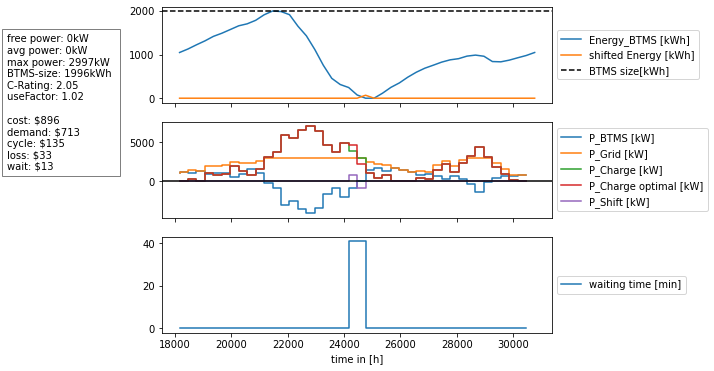

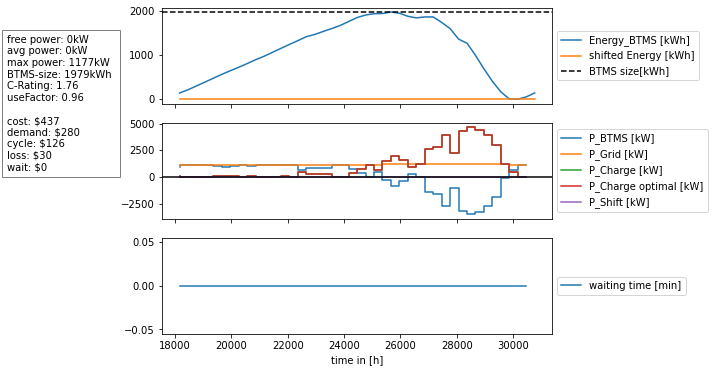

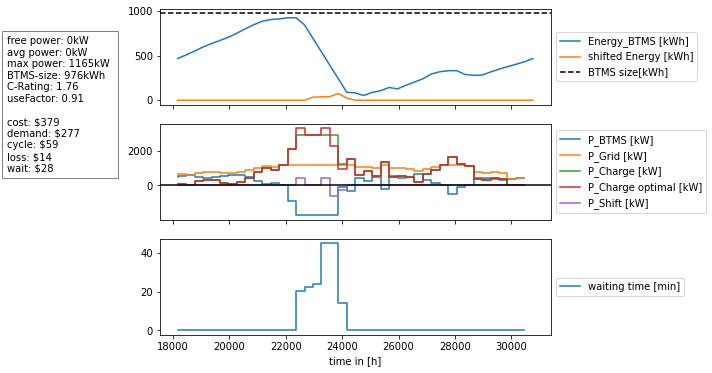

In [16]:
if chargingStationClass == components.ChaDepMpcBase:
    a = 50/30 * ((SimBroker.t_max - SimBroker.t_act)/3.6e3)/24  # demand charge cost
    P_free_Ratio    =  0            # free power, after which demand charge is applied, as ratio to avg power
    b = 300/5000                    # btms degradation cost
    c = 0.15                        # electricity cost
    d_param = 10                    # waiting time cost of a vehicle in $/h
    P_chAvg = 100                   # average charging speed in kW of an vehicle
    beta = 0.05                     # bandwith for energy level curve
    cRating = None                  # if choosen different from None, constraints to enforce c rate are applied

    Graph = True

    if True: # make a time varying d-vector
        x = chargingStations[0]
        time = np.array(x.PredictionTime)
        power = np.array(x.PredictionPower)
        idx = np.logical_and(time >=SimBroker.t_act, time <= SimBroker.t_max)
        time_new = time[idx]
        d = d_param # transformed to list by .planning() function
        #d = []
        #for i in range(0,sum(idx)):
            # for time varying vector
            # if time_new[i]< 21800:
            #     d.append(1)
            # elif time_new[i] < 26000:
            #     d.append(10)
            # elif time_new[i] < 28000:
            #     d.append(1)
            # elif time_new[i] < 29500:
            #     d.append(10)
            # else:
            #     d.append(2)
            #d.append(d_param)

    for x in chargingStations:
        avgPower = sum(x.PredictionPower*timestep)/(max(x.PredictionTime) + timestep - min(x.PredictionTime))
        P_free = P_free_Ratio *avgPower

        time, time_x, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, E_Shift, P_Charge, P_Shift, t_wait_val, cost_t_wait, cost = x.planning(SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, d, P_free, P_chAvg, beta, cRating)
        
        if Graph:
            cRating = max(abs(P_BTMS))/x.BtmsSize
            E_total = sum(timestep/3.6e3*P_Charge)
            avgPower = int(E_total/(max(time)-min(time) + timestep/3.6e3))
            useFactor = -sum(P_BTMS_DCh*timestep/3.6e3) / x.BtmsSize
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) + sum(P_BTMS_DCh*timestep/3.6e3)) # btmsDCh is always negative
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            costDemand = a*(max(P_Grid)-P_free)

            info_string1 = 'free power: ' + str(int(P_free)) + 'kW \navg power: '+ str(int(avgPower)) +'kW \nmax power: ' + str(int(max(P_Grid))) +'kW \nBTMS-size: ' + str(int(x.BtmsSize)) + 'kWh \nC-Rating: ' + "{:.2f}".format(cRating) + ' \nuseFactor: ' + "{:.2f}".format(useFactor) +' \n\ncost: $' + str(int(cost)) + ' \ndemand: $' +str(int(costDemand)) + '\ncycle: $' + str(int(costCycle)) + '\nloss: $' + str(int(costLoss)) +'\nwait: $' +str(int(cost_t_wait))

            fig, ax = plt.subplots(3,1, sharex = True)
            ax[0].plot(time_x, E_BTMS, label = "Energy_BTMS [kWh]")
            ax[0].plot(time_x, E_Shift, label = "shifted Energy [kWh]")
            ax[0].axhline(x.BtmsSize, label = "BTMS size[kWh]", color = "black", linestyle ="--")
            ax[0].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
            fig.text(-0.12, 0, info_string1, horizontalalignment='right', verticalalignment='center', multialignment = 'left', transform=ax[0].transAxes, bbox=dict(facecolor='none', edgecolor='grey', pad=5.0))
            #ax[0].text(0.5, 1, info_string2, horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

            ax[1].step(time, P_BTMS, label = "P_BTMS [kW]")
            ax[1].step(time, P_Grid, label = "P_Grid [kW]")
            ax[1].step(time, P_Charge-P_Shift, label = "P_Charge [kW]")
            ax[1].step(time, P_Charge, label = "P_Charge optimal [kW]")
            ax[1].step(time, P_Shift, label = "P_Shift [kW]")
            ax[1].axhline(0, color = 'black')
            ax[1].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

            if sum(t_wait_val)<0.0005:
                t_wait_val = np.zeros_like(t_wait_val)
            ax[2].step(time,t_wait_val*60, label = "waiting time [min]")
            ax[2].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

            ax[2].set_xlabel("time in [h]")

            fig.set_size_inches(7,6*3/3)

#### run simulation

In [17]:
SimBroker.reset()
ResultWriter.reset()
# charging station is not resetted

iteration = 0

while not SimBroker.eol():

    # Sim Broker Step
    slice = SimBroker.step(timestep)

    #update values from DERMS and PhysicalSimulation
    for x in chargingStations:
        # update SiteNet Power Limits from Derms
        GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
        x.updateFromDerms(GridPowerLower, GridPowerUpper)
        # update CES SOC from PhysicalSimulation
        x.updateFromPhySim(PhySimDummy.output(x.ChargingStationId))

    # generate Vehicles if charging Plug in event
    for i in range(0, len(slice)):
        if slice.iloc[i]["type"] == "ChargingPlugInEvent":
            # generate vehicle
            vehicle = VehicleGenerator.generateVehicleSO(slice.iloc[i])
            # let vehicle arrive at a charging station - here depending on taz
            taz = int(slice.iloc[i]["parkingTaz"]) # this is a str
            #find out which chargingStation belongs to the taz
            res = chargingStationMappedToTaz.isin([taz]).any().values
            index = np.where(res == True)[0][0]

            #let vehicles arrive at designated chargingStation
            chargingStations[index].arrival(vehicle, SimBroker.t_act)

    #control action and simulation
    
    # call step function
    for x in chargingStations:
        x.step(timestep)

    # provide outputs
    for x in chargingStations:
        PhySimDummy.input(x.ChargingStationId, sum(x.ChBaPower), x.BtmsPower, timestep)
        DermsDummy.input(x.ChargingStationId, x.PowerDesire)

    '''for testing'''
    if iteration>10:
         break
    iteration +=1
    #if SimBroker.t_act >= 26000:
    #    break
print("number of iterations:" +str(iteration))
    

P_BTMS:  1132.9188500130517
P_Charge:  0.004089207119511604
Charging Station Id:  chargingStation-1
iteration  0
ChBaPower:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
P_BTMS:  1009.6230574323253
P_Charge:  -0.00019153225815735032
Charging Station Id:  chargingStation-2
iteration  0
ChBaPower:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\cvxpy\problems\problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


P_BTMS:  1086.9395168403848
P_Charge:  124.71491139059059
Charging Station Id:  chargingStation-1
iteration  3
ChBaPower:  [0.29381356908803014, 124.42109782150256, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
P_BTMS:  1009.6221523228353
P_Charge:  0.0007503701070659019
Charging Station Id:  chargingStation-2
iteration  3
ChBaPower:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
print(chargingStations[2].ChBaVehicles[0] != 'hallo')

True


#### sneak peak into results

In [ ]:
VehicleEvents = ResultWriter.Events.loc[ResultWriter.Events.VehicleId == 2921283]
VehicleEvents.head(6)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
44,19663,ArrivalEvent,chargingStation-1,2921283,,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,NaN
49,19663,ReparkEvent,chargingStation-1,2921283,Bay,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,250.0
56,19663,ReleaseEvent,chargingStation-1,2921283,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,NaN


In [ ]:
df3 = ResultWriter.ChargingStationStates
df3.head(2)

,time,ChargingStationID,BaysVehicleIds,BaysChargingPower,TotalChargingPower,BaysChargingDesire,BaysNumberOfVehicles,QueueVehicleIds,QueueChargingDesire,QueueNumberOfVehicles,BtmsPower,BtmsSoc,BtmsEnergy,TotalChargingPowerDesire,GridPowerUpper,GridPowerLower,PowerDesire,BtmsPowerDesire,EnergyLagSum,TimeLagSum
0,18463,chargingStation-1,"[5270466, 3256681]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[inf, inf, nan, nan, nan, nan, nan, nan, nan, ...",2,[],[],0,26000.0,0.583333,15166.666667,0,104000.0,-104000.0,0,26000.0,0.0,0
1,18463,chargingStation-2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,25875.0,0.583333,15093.750000,0,103500.0,-103500.0,0,25875.0,0.0,0


In [ ]:
ResultWriter.chargingStationProperties

,ChargingStationId,BtmsSize,BtmsC,BtmsMaxPower,BtmsMaxSoc,BtmsMinSoc,ChBaNum,ChBaMaxPower,ChBaMaxPower_abs,ChBaParkingZoneId,GridPowerMax_Nom
0,chargingStation-1,26000.0,1,26000.0,0.8,0.2,208,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[X-PEV-9-1, X-PEV-11-1, X-PEV-12-1, X-PEV-21-1...",18200.0
1,chargingStation-2,25875.0,1,25875.0,0.8,0.2,207,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[AO-PEV-947-2425, AO-PEV-947-2426, AO-PEV-947-...",18112.5
2,chargingStation-3,11625.0,1,11625.0,0.8,0.2,93,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[AO-PEV-979-8367, AO-PEV-979-8368, AO-PEV-979-...",8137.5


#### save results

In [ ]:
ResultWriter.save()

#### plot results

In [ ]:
for y in chargingStations[0].Queue:
    print("delta t: " + str(y.VehicleDesEnd-y.VehicleArrival) + " delta E:" + str(y.VehicleDesEngy - y.VehicleEngy))
    print(y.updateEnergyLag(SimBroker.t_act))

(324.2835643998168, 2113.9908121687076)


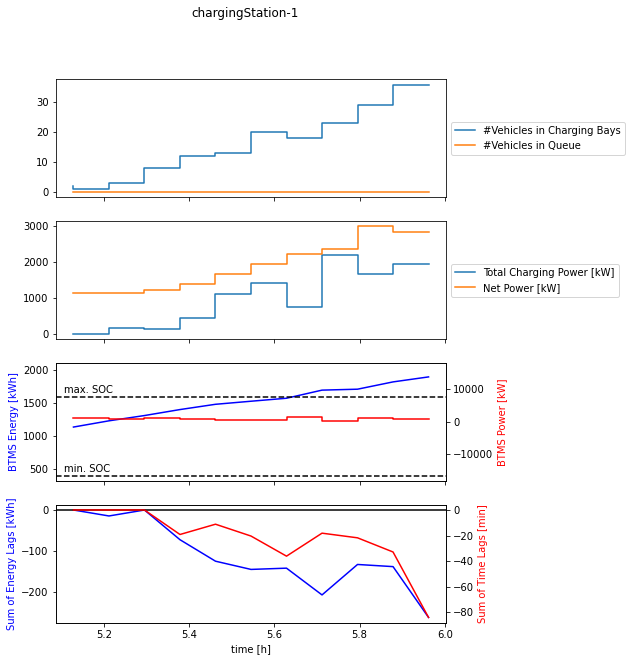

In [18]:
import matplotlib.pyplot as plt
loadDataFromFile = False
plotChargingStation = 0

if loadDataFromFile == True:
    # need to add code to load this from file
    pass
else:
    ChSt = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID == chargingStations[plotChargingStation].ChargingStationId]

fig, ax = plt.subplots(4,1, sharex=True)
fig.suptitle(chargingStations[plotChargingStation].ChargingStationId)
ax[0].step(ChSt.time/3600, ChSt.BaysNumberOfVehicles, label = "#Vehicles in Charging Bays")
ax[0].step(ChSt.time/3600, ChSt.QueueNumberOfVehicles, label = "#Vehicles in Queue")
ax[0].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
#ax[0].grid()

#ax[1].step(ChSt.time/3600, ChSt.GridPowerUpper, label = "Upper Power Limit [kW]")
ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower, label = "Total Charging Power [kW]")
ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower + ChSt.BtmsPower, label = "Net Power [kW]")
#ax[1].step(ChSt.time/3600, ChSt.BtmsPower, label = "Net Power [kW]")
ax[1].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
#ax[1].grid()

ax[2].plot(ChSt.time/3600, ChSt.BtmsEnergy, label = "BTMS Energy [kWh]", color = "blue")
ax[2].set_ylabel("BTMS Energy [kWh]", color = "blue")

y1=chargingStations[plotChargingStation].BtmsSize*chargingStations[plotChargingStation].BtmsMaxSoc
ax[2].axhline(y = y1, linestyle = "--", color ="black")

y2=chargingStations[plotChargingStation].BtmsSize*chargingStations[plotChargingStation].BtmsMinSoc
ax[2].axhline(y = y2, linestyle = "--", color ="black")
#ax[2].grid()

ylim = ax[2].get_ylim()
ax[2].set_ylim([ylim[0], 1.07*ylim[1]])
ylim = ax[2].get_ylim()
print(ylim)
dy = ylim[1]-ylim[0]
xlim = ax[2].get_xlim()
x = xlim[0]
dx = xlim[1]-xlim[0]
ax[2].text(x+0.02*dx, y1+0.03*dy, "max. SOC")
ax[2].text(x+0.02*dx, y2+0.03*dy, "min. SOC")

ax1 = ax[2].twinx()
ax1.step(ChSt.time/3600, ChSt.BtmsPower, label = "BTMS Power [kW]", color = "red")
ax1.set_ylabel("BTMS Power [kW]", color = "red")
ax1.set_ylim([-chargingStations[plotChargingStation].GridPowerMax_Nom, chargingStations[plotChargingStation].GridPowerMax_Nom])


ax[3].plot(ChSt.time/3600, ChSt.EnergyLagSum, label = "Sum of Energy Lags [kWh]", color ="blue")
ax[3].axhline(y = 0, color="black")
ax[3].set_ylabel("Sum of Energy Lags [kWh]", color = "blue")
#ax[3].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

ax2 = ax[3].twinx()
ax2.plot(ChSt.time/3600, ChSt.TimeLagSum/60, label= "Sum of Time Lags [min]", color = "red")
ax2.set_ylabel("Sum of Time Lags [min]", color ="red")

ax[3].set_xlabel("time [h]")

fig.set_size_inches(7, 10)